# Rank composites

Optical satellite imagery contains gaps due to clouds, and the observation scenario. Many methods rely on having gap-free data available at regular time intervals. The most common technique to achieve this is to combine pixels from different observations, which is also referred to as compositing.

Various compositing approaches exist, in this notebook, we demonstrate ‘rank composites’ or more specifically the ‘max NDVI’ composite. A rank composite uses a single ‘rank band’ to decide if pixels of other bands are included in the composite. The advantage of rank composites over compositing per band is that the spectral signal represented by the different bands has been observed in reality in a single observation, and is not a combination of spectral values that occurred at different points in time.

This method is used in various peer reviewed publications, and some of its properties have been validated based on specific sensors: https://www.tandfonline.com/doi/abs/10.1080/01431168608948945

In this case the 'rank band' is a simple NDVI, which we 'score' based on the maximum value. The rank band can also be a combination of values leading to a more complex score, such as distance to cloud and observation angles. This variant is called a 'best available pixel' composite. (https://doi.org/10.1080/07038992.2014.945827)

## openEO implementation

The steps to implement this method in openEO are relatively simple, but may be different from the steps in a 'traditional' programming language:

1. We load and compute the rank band separately
2. The rank band is converted into a mask, retaining only pixels that we want to select
3. A datacube with raw bands is loaded, and the rank band mask is applied to it
4. aggregate_temporal(_period) is used to create a composite at regular intervals if needed

Most methods require composites for multiple time periods as input. For instance, one composite per month, or every 10 days. We can compute these in one process graph, using apply_neighborhood, so that the result is also an immediate input for further processing.


In [1]:
spatial_extent = {'west': 4.45, 'east': 4.50, 'south': 51.16, 'north': 51.17, 'crs': 'epsg:4326'}

In [2]:
import openeo
import xarray
import numpy as np
import io
import requests

import panel as pn

import pyproj
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [3]:
c=openeo.connect("openeo.cloud")
c.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

We first create a binary cloud mask, as we don't want to consider clouded pixels. This is also a good way to avoid loading too much data, which is costly.

In [4]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-01"],
    bands = ["SCL"],
    max_cloud_cover=95
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)



/home/driesj/python/openeo-python-client/openeo/rest/connection.py:1133: UserWarning: SENTINEL2_L2A property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.
  return DataCube.load_collection(


Now we load the bands required to compute NDVI, apply the cloud mask, and compute NDVI. 
The NDVI will be our 'rank band' in this example.

In [5]:
ndvi_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-01"],
    bands = ["B04", "B08", "SCL"],
    max_cloud_cover=95
)

ndvi_bands = ndvi_bands.mask(cloud_mask)
#ndvi_bands = ndvi_bands.process("mask_scl_dilation", data=ndvi_bands, scl_band_name="SCL")

ndvi = ndvi_bands.ndvi(nir="B08",red="B04")

The next step is the most difficult one, and constructs the final mask that will be used to load the full datacube, but with only the observations where the NDVI is equal to the maximum.

We first create a function that computes the maximum NDVI from a series of values, and then loops again over those values to set values to 1 if they are equal to the maximum, and zero otherwise.

The apply_neighborhood process is used here to define the groups of NDVI values on which we want to run this function. We want to create multiple monthly max-NDVI composites, so we specify that the size of groups along the time dimension should correspond to 1 month. 
Apply_neighborhood is one of the more complex processes, but once you understand it, you'll notice it's quite versatile and useful.

In [6]:
def max_ndvi_selection(ndvi):
    max_ndvi = ndvi.max()
    return ndvi.array_apply(lambda x:x!=max_ndvi)

rank_mask = ndvi.apply_neighborhood(
        max_ndvi_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

At this point, we download our mask for inspection. This is just an intermediate result, and is not needed in a real use case.

In [7]:
rank_mask.filter_bbox(spatial_extent).execute_batch("the_mask.nc")

0:00:00 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': send 'start'
0:00:20 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:00:28 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:00:35 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:00:43 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:00:53 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:01:06 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:01:22 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:01:41 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:02:06 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': queued (progress N/A)
0:02:36 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': running (progress N/A)
0:03:14 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': running (progress N/A)
0:04:01 Job 'vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90': running (progress N/A)
0:05:

<BatchJob job_id='vito-j-ca99a93e1d7641d1b4e7a4714d7cfe90'>

In [8]:
mask_ds = xarray.open_dataset('the_mask.nc')
mask_ds

<xarray.Dataset>
Dimensions:  (t: 12, x: 352, y: 119)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-04 2022-06-11 ... 2022-07-24 2022-07-29
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    var      (t, y, x) uint8 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    description:  
    title:

We inspect the mask by filtering out nodata and plotting.

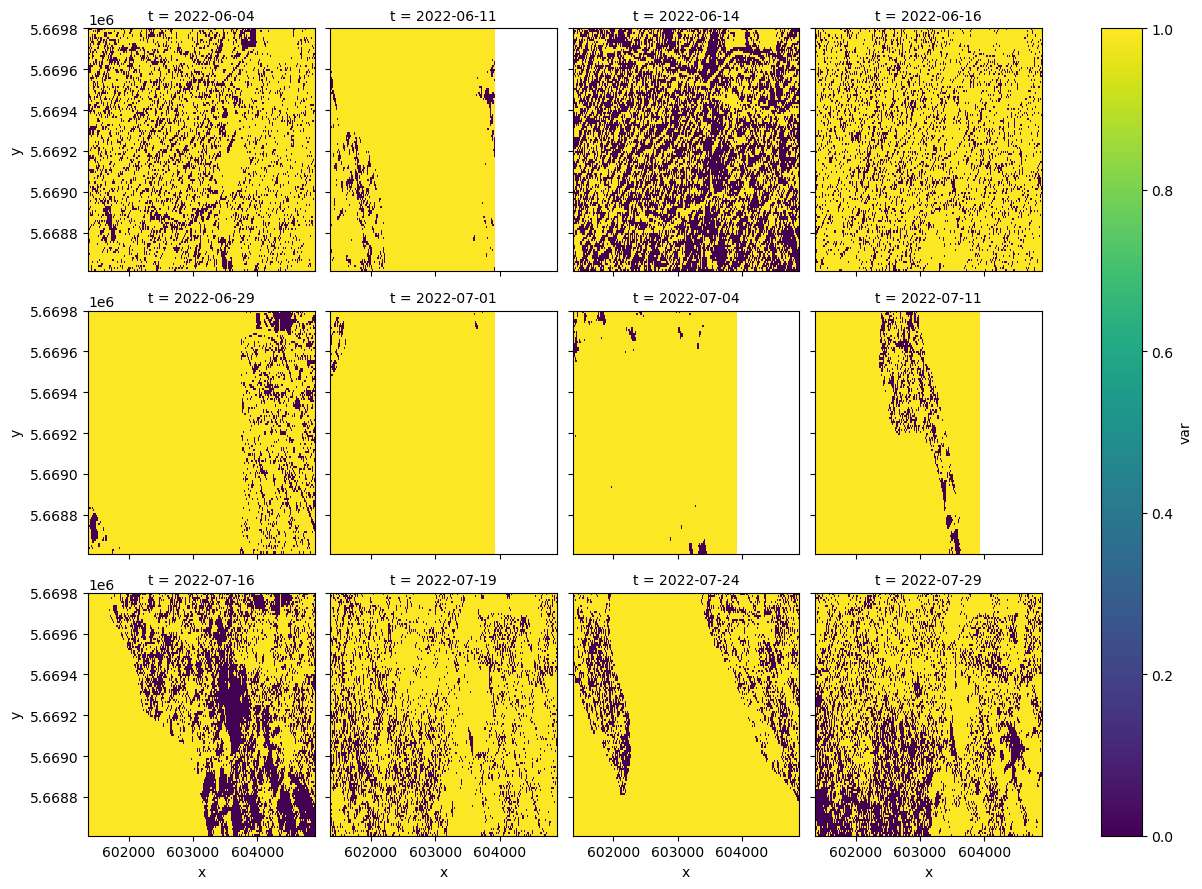

In [9]:
mask_ds['var'] = mask_ds['var'].where(mask_ds['var']!=129)
mask_ds['var'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

## Creating and downloading your composite

Now it's time to create and load the actual composite, which is very simply once a compositing mask has been created.
It's very important in this step to use the exact same 'load_collection' paratemers as were used to create the mask(s), to have a correct output.
Note that we still use aggregate_temporal_period, which has 2 effects:
- after masking, observations will still have their original dates, this process will generate equitemporal intervals.
- In the case where multiple observations have the same NDVI value, the first observation will be retained.

In [ ]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-01"],
    bands = ["B02", "B03","B04"],
    max_cloud_cover=95
)

composite = rgb_bands.mask(rank_mask).aggregate_temporal_period("month","first")

composite.filter_bbox(spatial_extent).execute_batch("composite.nc")

In [14]:
composite = xarray.open_dataset('composite.nc')
composite

<xarray.Dataset>
Dimensions:  (t: 2, x: 352, y: 119)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    B02      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    description:  
    title:

In [15]:

rgb_array=composite.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
rgb_array

<xarray.DataArray (bands: 3, t: 2, y: 119, x: 352)>
array([[[[0.1007, 0.1026, 0.0713, ..., 0.0566, 0.0427, 0.0598],
         [0.0868, 0.101 , 0.0811, ..., 0.083 , 0.0714, 0.104 ],
         [0.087 , 0.0872, 0.0858, ..., 0.13  , 0.097 , 0.1382],
         ...,
         [0.0996, 0.096 , 0.0677, ..., 0.0165, 0.0178, 0.0228],
         [0.0599, 0.059 , 0.0776, ..., 0.015 , 0.0168, 0.023 ],
         [0.0532, 0.0518, 0.0499, ..., 0.0145, 0.0156, 0.0192]],

        [[   nan,    nan, 0.0833, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [0.1098,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]],


       [[[0.0966, 0.0972, 0.0716, ..., 0.0665, 0.0536, 0.0714],
         [0.0845, 0.0871, 0.0762, ..., 0.0773, 0.072 , 0.1106],
         [0.083 , 0.083 , 0.0882, ..., 0.1206, 0.1004, 0.1616],
...
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]],


       [[[0.0732, 0.0776, 0.0601, ..., 0.0479, 0.0394, 0.0458],
         [0.0676, 0.078 , 0.0606, ..., 0.0708, 0.0594, 0.0787],
         [0.0746, 0.0784, 0.0802, ..., 0.1036, 0.0727, 0.145 ],
         ...,
         [0.0742, 0.0708, 0.0469, ..., 0.0196, 0.018 , 0.0236],
         [0.0438, 0.0426, 0.0546, ..., 0.0188, 0.0182, 0.0208],
         [0.0429, 0.0431, 0.0418, ..., 0.0179, 0.0188, 0.0206]],

        [[   nan,    nan, 0.093 , ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [0.1146,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]]],
      dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
  * bands    (bands) object 'B04' 'B03' 'B02'

## Final result & conclusion
We finally plot composites generated for 2 months. 
While this notebook ends here, for most real world cases, this is the point where you can start your actual work, as you now have gap-free equitemporal composites. 
Note that in openEO, things happen on the fly, and this method is quite efficient, so there's no need to actually store these intermediate composites somewhere before movin on, you can just take the composited data cube, and go from there!

### Note on performance
This approach was designed with efficiency in mind: we explicitly load a minimum amount of bands to construct the mask. As a result if observations are not used in the composite at all, they do not need to be loaded for the final result.
The max-NDVI approach is however somewhat limited in this regard, because the plots of the mask show that often many chunks are needed for the final output.

One other remark is that it could be an option to construct the mask at lower resolution: this would further reduce data loading times, at the cost of a somewhat less accurate max-NDVI composite.


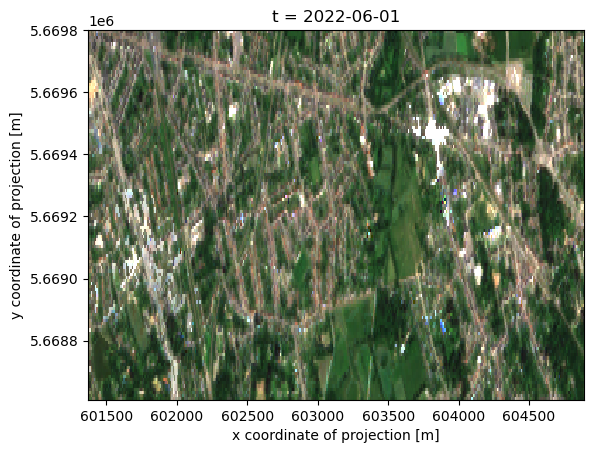

In [18]:
xarray.plot.imshow(rgb_array.isel(t=0),vmin=0,vmax=0.18,rgb="bands",col_wrap=2)